In [1]:
# Useful links
# https://www.kaggle.com/richardnnamdi/customer-segmentation-ltv#Customer-Segmentation
# https://towardsdatascience.com/data-driven-growth-with-python-part-2-customer-segmentation-5c019d150444

## Background

[Olist](https://olist.com/) is an e-commerce platform that connects merchants and their products to the marketplaces of Brazil. Merchants are able to sell their products through the Olist Store and ship them directly to customers using Olist logistics partners. 

## Problem statement

Instead of analysing the entire customer base as a whole, Olist's marketing team would like to understand the behaviour of each customer segment. A customer segmentation model (RFM framework) will allow Olist to identify users and target them with differentiated and personalised marketing strategies. This will improve user engagement and retention.

## Dataset

We will be using real commercial data provided by Olist and hosted on [Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce). The dataset consists of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

## Import data

In [3]:
customers = pd.read_csv('./data/olist_customers_dataset.csv')
orders = pd.read_csv('./data/olist_orders_dataset.csv', 
                     parse_dates=['order_purchase_timestamp', 
                                  'order_approved_at', 
                                  'order_delivered_carrier_date',
                                  'order_delivered_customer_date',
                                 'order_estimated_delivery_date'])
order_items = pd.read_csv('./data/olist_order_items_dataset.csv', parse_dates=['shipping_limit_date'])
order_payments = pd.read_csv('./data/olist_order_payments_dataset.csv')

In [4]:
dfs = [customers, orders, order_items, order_payments]

# Print shape of our datasets
for df in dfs:
    print(df.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(103886, 5)


## Data cleaning

In [5]:
# Merge 4 datasets into 1 dataframe
df1 = order_items.merge(order_payments, on='order_id')
df2 = df1.merge(orders, on='order_id')
df = df2.merge(customers, on='customer_id')

In [6]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,1,credit_card,2,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,1,credit_card,3,...,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,1,credit_card,5,...,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,1,credit_card,2,...,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,1,credit_card,3,...,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       117601 non-null  object        
 1   order_item_id                  117601 non-null  int64         
 2   product_id                     117601 non-null  object        
 3   seller_id                      117601 non-null  object        
 4   shipping_limit_date            117601 non-null  datetime64[ns]
 5   price                          117601 non-null  float64       
 6   freight_value                  117601 non-null  float64       
 7   payment_sequential             117601 non-null  int64         
 8   payment_type                   117601 non-null  object        
 9   payment_installments           117601 non-null  int64         
 10  payment_value                  117601 non-null  float64       
 11  

In [8]:
# Check for null values
df.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1245
order_delivered_customer_date    2567
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

There are quite a few null values in `order_approved_at`, `order_delivered_carrier_date` and `order_delivered_customer_date`. Let's investigate further and decide on how we should treat these null values.

In [9]:
df[df['order_delivered_customer_date'].isnull()]['order_status'].value_counts()

shipped        1244
canceled        559
processing      375
invoiced        371
delivered         8
unavailable       7
approved          3
Name: order_status, dtype: int64

After some investigation, we noticed that the null values in `order_delivered_customer_date` are a result of deliveries that were not `delivered`. The `order_status` was in fact `shipped`, `canceled` etc. As we would like to build a customer segmentation model that analyses on orders that were delivered, we will only keep these orders that have fulfilled this order status.

In [10]:
# We will only keep orders that were delivered
df = df[df['order_status']=='delivered']

In [11]:
df.isnull().sum()

order_id                          0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
payment_sequential                0
payment_type                      0
payment_installments              0
payment_value                     0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
customer_zip_code_prefix          0
customer_city                     0
customer_state                    0
dtype: int64

There are now much fewer null values than before. As the remaining null values may have been a result of a system lapse or human error, we can assume that the occurrence of missing values is random (Missing Completely at Random).

## Customer segmentation model: RFM framework

We will use the RFM framework to build our customer segmentation model. RFM stands for Recency, Frequency, Monetary Value. This would allow us to create the following segments:
- Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero maybe negative revenue.
- Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
- High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.


## Recency

Recency can be calculated by finding the number of days since customers' last purchase. After obtaining the number of inactive days, we can apply K-means clustering to assign each customer a recency score.

In [12]:
# Create a dataframe to store customers uuid and recency scores
recency = df[['customer_unique_id', 'order_purchase_timestamp']]

In [13]:
# Since a customer may have more than one order, we will obtain his/her last purchase timestamp
recency = recency.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
recency.columns = ['customer_unique_id', 'last_purchase_timestamp']

# Calculate the number of days since customers' last purchase
recency['inactive_days'] = (recency['last_purchase_timestamp'].max() - recency['last_purchase_timestamp']).dt.days
recency.drop(columns='last_purchase_timestamp', inplace=True)

In [14]:
recency.head()

,customer_unique_id,inactive_days
0,0000366f3b9a7992bf8c76cfdf3221e2,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114
2,0000f46a3911fa3c0805444483337064,536
3,0000f6ccb0745a6a4b88665a16c9f078,320
4,0004aac84e0df4da2b147fca70cf8255,287


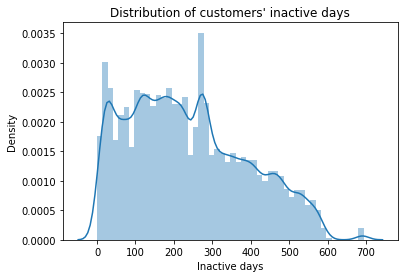

In [15]:
sns.distplot(recency['inactive_days'], bins=50)
plt.xlabel('Inactive days')
plt.ylabel('Density')
plt.title("Distribution of customers' inactive days");

We will use K-means clustering to assign each customer with a recency score. But first, we will use the Elbow method to identify the optimal number of clusters here.

In [16]:
inertia = {}

# X = recency[['inactive_days']]

for k in range(1,10):
    km = KMeans(n_clusters=k)
    km = km.fit(recency[['inactive_days']])
    inertia[k] = km.inertia_

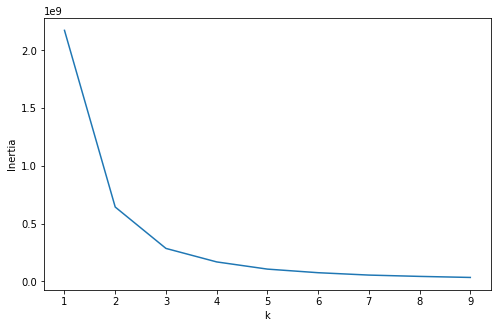

In [17]:
plt.figure(figsize=(8,5))
plt.plot(list(inertia.keys()), list(inertia.values()))
plt.xlabel('k')
plt.ylabel('Inertia');

As seen above, the elbow on the arm is the optimal k, which in this case is 3.

In [18]:
km = KMeans(n_clusters=3)
km.fit(recency[['inactive_days']])
recency['clusters'] = km.labels_

In [19]:
recency.groupby('clusters')['inactive_days'].describe()

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,35425.0,253.414735,51.376230,170.0,209.0,256.0,290.0,354.0
1,22039.0,456.284450,68.933645,355.0,398.0,449.0,507.0,694.0
2,35893.0,85.989664,49.367827,0.0,39.0,86.0,128.0,169.0
